# Interpretable ML

Interpretable Machine Learning (ML) is a critical aspect of advancing the use of machine learning in various fields. Many black box models hinder ML's adoption due to their lack of transparency and interpretability. In this project, we employ a range of techniques to shed light on these complex models, providing valuable insights and making them more accessible for practical application.

In [68]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1.Partial Dependence Plots
### 1.1 Clean data

Partial Dependence Plots (PDPs) serve as a valuable tool for comprehending the connection between variables and model responses.

PDPs enable us to visualize the relationship between the target variable and each individual independent variable, effectively validating the impact of all other variables.

For a hands-on demonstration, we will utilize the bike rentals dataset available at https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset. This dataset focuses on regression, specifically the count of bike rentals on a given day, which depends on various factors. We will construct partial dependence plots to explore how weather-related variables, such as humidity, windspeed, and temperature, influence the rental count in this dataset.

In [69]:
bike_day_df_raws = pd.read_csv('./data/day.csv')
bike_day_df_raws.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [70]:
bike_day_df_raws.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


Data types look good.

In [71]:
# Missing data
bike_day_df_raws.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

No missing data in this set.

### 1.2 Run models
In this part, we run a Boosting model on data with 4 features and then use PDPs to check which variables are the most important and could explain well the Bike Rental count. 

In [72]:
import sklearn
print(sklearn.__version__)

1.2.1


In [73]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay

In [74]:
# Keep only some features
df = bike_day_df_raws[["temp", "hum", "windspeed", "cnt"]]

# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :3], # train for first 3 variables
                                                    df.iloc[:, 3], # test is the last variable
                                                    test_size=0.2, # 20% for testing
                                                    random_state = 123)

# Fit model by default
model = GradientBoostingRegressor(random_state = 123)
model.fit(X_train, y_train)

# Evaluate model using R squared
score = model.score(X_test, y_test)
score

0.45235313872881266

The model does not perform well but we just need to demonstrate how PDP works, so I will move to next part.

### 1.3 Explain model by Partial Dependence Plot

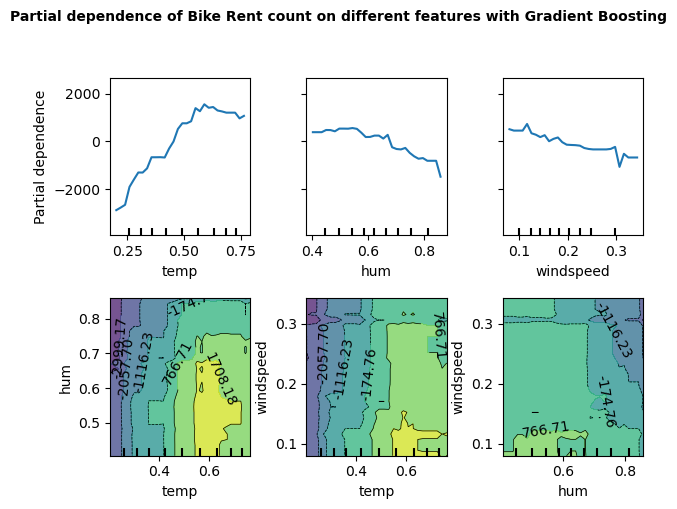

In [75]:
# Create the partial dependence display
pdp = PartialDependenceDisplay.from_estimator(model, 
                                              X_train, 
                                              features = ["temp", "hum", "windspeed", 
                                                          ("temp", "hum"), ("temp", "windspeed"), ("hum", "windspeed")], 
                                              #kind="both", 
                                              grid_resolution=30)

# Adjust the subplots spacing
pdp.figure_.subplots_adjust(wspace=0.4, hspace=0.4)

# Set the suptitle
plt.suptitle("Partial dependence of Bike Rent count on different features with Gradient Boosting", y=1.05, fontsize=10, fontweight='bold')

# Tighten the layout
plt.tight_layout()

To know more about the concept of PDP, please visit this intuitive video: https://www.youtube.com/watch?v=uQQa3wQgG_s&ab_channel=ritvikmath

**Explain**:

**- 1: One way interaction:**
The y axis represents the number of bikes rented, while the x axis shows each feature.

Among 3 features, we can see that temperature affects the target variable the most.
When **temperature** is high, more bikes are rented. This makes sense in reality, because people usually bike when the weather is warm and hot. In winter time, it is not ideal to cycle around. From the first plot, we can also see that, when temperature reachs to a certain level, the number of rented bikes is relatively constant.

On contrast, when humidity and wind speed increase (maybe the weather is rain), the number of rented bikes is decreased. 

**Conclusion**: This plot can help us with 2 critical questions:
- 1: How each feature affects the target variable (direction)
- 2: How strong each feature could impact the target variable (serverity) 

**- 2: Two-way interaction:**
The second line of plot is a type of heatmap that show how 2 features can influence the target variable. For example:

`("temp", "hum")`: This is a two-way partial dependence plot for the interaction between temperature ("temp") and humidity ("hum"). It shows how the predicted target variable changes as both temperature and humidity vary. This plot can help you understand how the combination of temperature and humidity influences the target variable. In the plot, the lighter color is more bikes rented. Specifically, in the first interaction plot, rent is high when temperature is warm enough and humidity is low (no rain).

**Weakness of PDP**: One assumption that PDP takes is all features (k) are independent, in which we could keep k - 1 features constant and change 1 feature at a time with different range of values to check the effect of it on the performance of model. However, this assumption does not hold true as usually, predictors are related at somewhat level. For example, terperature could be related to humidity, thus when we change temperature but keep humidity the same, this already distorts the essence of data.

## 2. LIME

### 2.0 Overview
Local Interpretable Model-agnostic Explanations (LIME) is a framework and technique designed to provide interpretability and insights into the predictions of complex machine learning models. It focuses on explaining the decisions made by black-box models by approximating their behavior with simpler, more interpretable models.

Here's how LIME works:

1. **Select a Data Point**: Start by selecting a data point or instance for which you want an explanation. This is typically a single data point for which you want to understand why the model made a particular prediction.

2. **Generate Perturbed Data**: LIME creates a dataset of perturbed instances by making small, random modifications to the selected data point. These modifications can include adding or changing features while keeping some of the original features constant. The goal is to create a diverse set of data points that represent the local neighborhood of the original instance.

3. **Get Model Predictions**: For each of the perturbed instances, LIME uses the machine learning model (the one you want to explain) to obtain predictions. These predictions serve as labels for the perturbed instances.

4. **Fit a Local Model**: LIME then fits an interpretable model, often a linear model like a logistic regression or a decision tree, to the perturbed data points and their corresponding model predictions. The goal is to create a model that approximates the behavior of the black-box model in the local neighborhood of the selected instance.

5. **Weighted Sampling**: The perturbed instances are often weighted based on their similarity to the original instance and the quality of their fit to the local model. This helps ensure that instances that are more similar to the original data point have a stronger influence on the explanation.

6. **Generate Explanations**: The fitted local model is used to generate feature importance scores. These scores indicate which features had the most influence on the model's prediction for the selected instance. The higher the weight for a feature, the more important that feature was in making the prediction.

7. **Present the Explanation**: The feature importance scores can be used to explain why the model made a particular prediction for the selected data point. These explanations can take various forms, such as highlighting important features, showing which features contributed to the prediction, or providing textual explanations.

LIME works by generating a dataset of perturbed or sampled instances from the original data and observing the corresponding predictions of the black-box model. It then fits a simple interpretable model (often a linear or decision tree model) to this generated dataset, effectively modeling the local behavior of the complex model around a specific instance. This local model provides an interpretable explanation for the prediction made by the black-box model for that instance.

The key idea behind LIME is to make model-agnostic explanations, meaning it can be applied to any machine learning model without needing to know its internal structure. LIME is particularly valuable in cases where transparency and trust in model predictions are essential, such as in healthcare, finance, and legal applications.

**Some examples:**

- **Tabular Data**:
![Tablular](./image/Tabular_Data.png)
LIME will generate data and work on simpler model (like Logistic Regression) and then it give us the feature importance to explain the model. Like in the above example, it ranks features in order and which one could explain for each class of data.

- **Text Data**:
![NLP](./image/NLP.png)
In this example, LIME give us the list of words that make the corpus `Atheism` or `Not Atheism` using simpler models like Decision Tree or Naive Bayes.

- **Image Data**:
![Image](./image/Image.png)
In this example, LIME give us which features from the image that could help us classify that is a dog. As you can see, the important features here to recognize a dog is: eyes, forehead, nose (a part), chin. 


Image credit to: https://www.youtube.com/watch?v=vz_fkVkoGFM&ab_channel=CristianArteaga

In [3]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import skimage

### 2.1 Using a pretrained Inception model to predict the image

**Step 1: Import Required Libraries**

First, import the necessary libraries and modules. You'll need `lime`, `matplotlib`, and a deep learning framework for image classification. In this example, we'll use Keras with TensorFlow as the backend.

In [76]:
import lime
from lime import lime_image
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
import numpy as np

**Step 2: Load and Preprocess an Image**

You can use Keras to load and preprocess an image.

In [31]:
# Load and preprocess the image
image_path = './data/Dog_cat_1.png'  # Replace with the path to your image
img = image.load_img(image_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

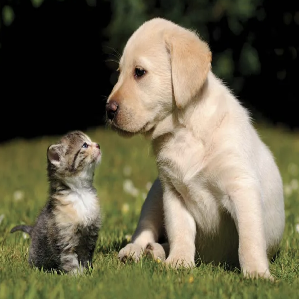

In [39]:
#Show the image
img

**Step 3: Load a Pretrained Model**

Load a pretrained image classification model. In this example, we'll use InceptionV3.

In [32]:
inet_model = InceptionV3()

**Step 4: Create a LIME Explainer**

Create a LIME explainer for image classification using the `LIMEImageExplainer` class. You need to pass your model and a function that takes raw images as input and returns predicted probabilities. In this example, we'll use a simple wrapper function for the InceptionV3 model.

In [34]:
explainer = lime_image.LimeImageExplainer()
def predict_fn(images):
    return inet_model.predict(images)

**Step 5: Generate Explanations with LIME**

Use LIME to generate explanations for the image classification. You can specify the number of superpixels and the number of samples for explanations.

To see more parameters of this explain function, please check this link: https://lime-ml.readthedocs.io/en/latest/lime.html

All parameters of the function: `explain_instance(image, classifier_fn, labels=(1, ), hide_color=None, top_labels=5, num_features=100000, num_samples=1000, batch_size=10, segmentation_fn=None, distance_metric='cosine', model_regressor=None, random_seed=None, progress_bar=True)`

However, in this code, I only change:

`top_labels=5:` This parameter specifies how many top labels or classes LIME should consider when generating explanations. In this case, it will generate explanations for the top 5 predicted labels or classes by the model.

`hide_color=0:` This parameter defines the color that should be used to hide the image's pixels when creating the perturbed samples for explanation. A value of 0 means no color is hidden, so all pixel values are used for perturbed samples.

`num_samples=2000:` This parameter specifies the number of perturbed samples to be used by LIME to explain the model's predictions. LIME generates a set of perturbed samples to understand how different inputs might affect the model's predictions. A larger number of samples can result in more stable and accurate explanations, but it may also increase computation time.

In [40]:
explanation = explainer.explain_instance(x[0], 
                                         predict_fn, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=2000)

  0%|                                                  | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 453ms/step


  0%|▏                                        | 10/2000 [00:00<01:58, 16.78it/s]

1/1 [==============================] - 0s 368ms/step


  1%|▍                                        | 20/2000 [00:01<01:38, 20.05it/s]

1/1 [==============================] - 0s 384ms/step


  2%|▌                                        | 30/2000 [00:01<01:33, 21.05it/s]

1/1 [==============================] - 0s 366ms/step


  2%|▊                                        | 40/2000 [00:01<01:29, 21.85it/s]

1/1 [==============================] - 0s 371ms/step


  2%|█                                        | 50/2000 [00:02<01:27, 22.21it/s]

1/1 [==============================] - 0s 415ms/step


  3%|█▏                                       | 60/2000 [00:02<01:29, 21.80it/s]

1/1 [==============================] - 0s 365ms/step


  4%|█▍                                       | 70/2000 [00:03<01:26, 22.27it/s]

1/1 [==============================] - 0s 370ms/step


  4%|█▋                                       | 80/2000 [00:03<01:24, 22.59it/s]

1/1 [==============================] - 0s 375ms/step


  4%|█▊                                       | 90/2000 [00:04<01:24, 22.65it/s]

1/1 [==============================] - 0s 377ms/step


  5%|██                                      | 100/2000 [00:04<01:23, 22.72it/s]

1/1 [==============================] - 0s 392ms/step


  6%|██▏                                     | 110/2000 [00:05<01:23, 22.54it/s]

1/1 [==============================] - 0s 371ms/step


  6%|██▍                                     | 120/2000 [00:05<01:22, 22.73it/s]

1/1 [==============================] - 0s 408ms/step


  6%|██▌                                     | 130/2000 [00:05<01:24, 22.21it/s]

1/1 [==============================] - 0s 427ms/step


  7%|██▊                                     | 140/2000 [00:06<01:25, 21.65it/s]

1/1 [==============================] - 0s 379ms/step


  8%|███                                     | 150/2000 [00:06<01:24, 21.95it/s]

1/1 [==============================] - 0s 408ms/step


  8%|███▏                                    | 160/2000 [00:07<01:24, 21.75it/s]

1/1 [==============================] - 0s 380ms/step


  8%|███▍                                    | 170/2000 [00:07<01:23, 21.98it/s]

1/1 [==============================] - 0s 372ms/step


  9%|███▌                                    | 180/2000 [00:08<01:21, 22.28it/s]

1/1 [==============================] - 0s 368ms/step


 10%|███▊                                    | 190/2000 [00:08<01:20, 22.58it/s]

1/1 [==============================] - 0s 456ms/step


 10%|████                                    | 200/2000 [00:09<01:23, 21.49it/s]

1/1 [==============================] - 0s 411ms/step


 10%|████▏                                   | 210/2000 [00:09<01:23, 21.31it/s]

1/1 [==============================] - 0s 388ms/step


 11%|████▍                                   | 220/2000 [00:10<01:22, 21.56it/s]

1/1 [==============================] - 0s 372ms/step


 12%|████▌                                   | 230/2000 [00:10<01:20, 21.99it/s]

1/1 [==============================] - 0s 373ms/step


 12%|████▊                                   | 240/2000 [00:10<01:19, 22.25it/s]

1/1 [==============================] - 0s 420ms/step


 12%|█████                                   | 250/2000 [00:11<01:20, 21.79it/s]

1/1 [==============================] - 0s 383ms/step


 13%|█████▏                                  | 260/2000 [00:11<01:19, 21.97it/s]

1/1 [==============================] - 0s 368ms/step


 14%|█████▍                                  | 270/2000 [00:12<01:17, 22.40it/s]

1/1 [==============================] - 0s 371ms/step


 14%|█████▌                                  | 280/2000 [00:12<01:15, 22.64it/s]

1/1 [==============================] - 0s 373ms/step


 14%|█████▊                                  | 290/2000 [00:13<01:15, 22.75it/s]

1/1 [==============================] - 0s 370ms/step


 15%|██████                                  | 300/2000 [00:13<01:14, 22.90it/s]

1/1 [==============================] - 0s 366ms/step


 16%|██████▏                                 | 310/2000 [00:14<01:13, 23.05it/s]

1/1 [==============================] - 0s 426ms/step


 16%|██████▍                                 | 320/2000 [00:14<01:15, 22.25it/s]

1/1 [==============================] - 0s 377ms/step


 16%|██████▌                                 | 330/2000 [00:14<01:14, 22.42it/s]

1/1 [==============================] - 0s 373ms/step


 17%|██████▊                                 | 340/2000 [00:15<01:13, 22.62it/s]

1/1 [==============================] - 0s 366ms/step


 18%|███████                                 | 350/2000 [00:15<01:12, 22.89it/s]

1/1 [==============================] - 0s 373ms/step


 18%|███████▏                                | 360/2000 [00:16<01:11, 22.96it/s]

1/1 [==============================] - 0s 375ms/step


 18%|███████▍                                | 370/2000 [00:16<01:11, 22.93it/s]

1/1 [==============================] - 0s 364ms/step


 19%|███████▌                                | 380/2000 [00:17<01:10, 23.07it/s]

1/1 [==============================] - 0s 364ms/step


 20%|███████▊                                | 390/2000 [00:17<01:09, 23.19it/s]

1/1 [==============================] - 0s 366ms/step


 20%|████████                                | 400/2000 [00:17<01:08, 23.32it/s]

1/1 [==============================] - 0s 384ms/step


 20%|████████▏                               | 410/2000 [00:18<01:08, 23.11it/s]

1/1 [==============================] - 0s 371ms/step


 21%|████████▍                               | 420/2000 [00:18<01:08, 23.10it/s]

1/1 [==============================] - 0s 370ms/step


 22%|████████▌                               | 430/2000 [00:19<01:07, 23.14it/s]

1/1 [==============================] - 0s 370ms/step


 22%|████████▊                               | 440/2000 [00:19<01:07, 23.18it/s]

1/1 [==============================] - 0s 371ms/step


 22%|█████████                               | 450/2000 [00:20<01:06, 23.17it/s]

1/1 [==============================] - 0s 382ms/step


 23%|█████████▏                              | 460/2000 [00:20<01:07, 22.98it/s]

1/1 [==============================] - 0s 367ms/step


 24%|█████████▍                              | 470/2000 [00:20<01:06, 23.09it/s]

1/1 [==============================] - 0s 378ms/step


 24%|█████████▌                              | 480/2000 [00:21<01:06, 23.01it/s]

1/1 [==============================] - 0s 380ms/step


 24%|█████████▊                              | 490/2000 [00:21<01:05, 22.90it/s]

1/1 [==============================] - 0s 390ms/step


 25%|██████████                              | 500/2000 [00:22<01:06, 22.68it/s]

1/1 [==============================] - 0s 393ms/step


 26%|██████████▏                             | 510/2000 [00:22<01:06, 22.53it/s]

1/1 [==============================] - 0s 375ms/step


 26%|██████████▍                             | 520/2000 [00:23<01:05, 22.66it/s]

1/1 [==============================] - 0s 369ms/step


 26%|██████████▌                             | 530/2000 [00:23<01:04, 22.76it/s]

1/1 [==============================] - 0s 377ms/step


 27%|██████████▊                             | 540/2000 [00:24<01:03, 22.82it/s]

1/1 [==============================] - 0s 369ms/step


 28%|███████████                             | 550/2000 [00:24<01:03, 22.95it/s]

1/1 [==============================] - 0s 368ms/step


 28%|███████████▏                            | 560/2000 [00:24<01:02, 23.03it/s]

1/1 [==============================] - 0s 364ms/step


 28%|███████████▍                            | 570/2000 [00:25<01:01, 23.14it/s]

1/1 [==============================] - 0s 371ms/step


 29%|███████████▌                            | 580/2000 [00:25<01:01, 23.16it/s]

1/1 [==============================] - 0s 376ms/step


 30%|███████████▊                            | 590/2000 [00:26<01:01, 23.09it/s]

1/1 [==============================] - 0s 396ms/step


 30%|████████████                            | 600/2000 [00:26<01:01, 22.71it/s]

1/1 [==============================] - 0s 421ms/step


 30%|████████████▏                           | 610/2000 [00:27<01:03, 22.00it/s]

1/1 [==============================] - 1s 520ms/step


 31%|████████████▍                           | 620/2000 [00:27<01:07, 20.31it/s]

1/1 [==============================] - 0s 434ms/step


 32%|████████████▌                           | 630/2000 [00:28<01:07, 20.24it/s]

1/1 [==============================] - 0s 410ms/step


 32%|████████████▊                           | 640/2000 [00:28<01:06, 20.52it/s]

1/1 [==============================] - 0s 388ms/step


 32%|█████████████                           | 650/2000 [00:29<01:04, 21.00it/s]

1/1 [==============================] - 0s 374ms/step


 33%|█████████████▏                          | 660/2000 [00:29<01:02, 21.54it/s]

1/1 [==============================] - 0s 376ms/step


 34%|█████████████▍                          | 670/2000 [00:30<01:00, 21.98it/s]

1/1 [==============================] - 0s 375ms/step


 34%|█████████████▌                          | 680/2000 [00:30<00:59, 22.27it/s]

1/1 [==============================] - 0s 380ms/step


 34%|█████████████▊                          | 690/2000 [00:30<00:58, 22.33it/s]

1/1 [==============================] - 0s 373ms/step


 35%|██████████████                          | 700/2000 [00:31<00:57, 22.53it/s]

1/1 [==============================] - 0s 462ms/step


 36%|██████████████▏                         | 710/2000 [00:31<01:00, 21.40it/s]

1/1 [==============================] - 0s 439ms/step


 36%|██████████████▍                         | 720/2000 [00:32<01:01, 20.90it/s]

1/1 [==============================] - 0s 495ms/step


 36%|██████████████▌                         | 730/2000 [00:32<01:03, 19.92it/s]

1/1 [==============================] - 0s 439ms/step


 37%|██████████████▊                         | 740/2000 [00:33<01:03, 19.94it/s]

1/1 [==============================] - 0s 368ms/step


 38%|███████████████                         | 750/2000 [00:33<01:00, 20.83it/s]

1/1 [==============================] - 0s 385ms/step


 38%|███████████████▏                        | 760/2000 [00:34<00:58, 21.30it/s]

1/1 [==============================] - 0s 423ms/step


 38%|███████████████▍                        | 770/2000 [00:34<00:58, 20.87it/s]

1/1 [==============================] - 0s 410ms/step


 39%|███████████████▌                        | 780/2000 [00:35<00:58, 20.97it/s]

1/1 [==============================] - 0s 365ms/step


 40%|███████████████▊                        | 790/2000 [00:35<00:55, 21.71it/s]

1/1 [==============================] - 0s 469ms/step


 40%|████████████████                        | 800/2000 [00:36<00:57, 20.78it/s]

1/1 [==============================] - 0s 454ms/step


 40%|████████████████▏                       | 810/2000 [00:36<00:58, 20.31it/s]

1/1 [==============================] - 0s 439ms/step


 41%|████████████████▍                       | 820/2000 [00:37<00:58, 20.17it/s]

1/1 [==============================] - 0s 384ms/step


 42%|████████████████▌                       | 830/2000 [00:37<00:56, 20.79it/s]

1/1 [==============================] - 0s 368ms/step


 42%|████████████████▊                       | 840/2000 [00:38<00:53, 21.52it/s]

1/1 [==============================] - 0s 370ms/step


 42%|█████████████████                       | 850/2000 [00:38<00:52, 21.89it/s]

1/1 [==============================] - 0s 368ms/step


 43%|█████████████████▏                      | 860/2000 [00:38<00:51, 22.33it/s]

1/1 [==============================] - 0s 371ms/step


 44%|█████████████████▍                      | 870/2000 [00:39<00:50, 22.60it/s]

1/1 [==============================] - 0s 363ms/step


 44%|█████████████████▌                      | 880/2000 [00:39<00:48, 22.87it/s]

1/1 [==============================] - 0s 369ms/step


 44%|█████████████████▊                      | 890/2000 [00:40<00:48, 23.00it/s]

1/1 [==============================] - 0s 397ms/step


 45%|██████████████████                      | 900/2000 [00:40<00:48, 22.62it/s]

1/1 [==============================] - 0s 364ms/step


 46%|██████████████████▏                     | 910/2000 [00:41<00:47, 22.89it/s]

1/1 [==============================] - 0s 367ms/step


 46%|██████████████████▍                     | 920/2000 [00:41<00:46, 23.01it/s]

1/1 [==============================] - 0s 372ms/step


 46%|██████████████████▌                     | 930/2000 [00:42<00:46, 23.02it/s]

1/1 [==============================] - 0s 369ms/step


 47%|██████████████████▊                     | 940/2000 [00:42<00:45, 23.08it/s]

1/1 [==============================] - 0s 373ms/step


 48%|███████████████████                     | 950/2000 [00:42<00:45, 23.06it/s]

1/1 [==============================] - 0s 392ms/step


 48%|███████████████████▏                    | 960/2000 [00:43<00:45, 22.76it/s]

1/1 [==============================] - 0s 377ms/step


 48%|███████████████████▍                    | 970/2000 [00:43<00:45, 22.79it/s]

1/1 [==============================] - 0s 371ms/step


 49%|███████████████████▌                    | 980/2000 [00:44<00:44, 22.94it/s]

1/1 [==============================] - 0s 376ms/step


 50%|███████████████████▊                    | 990/2000 [00:44<00:44, 22.93it/s]

1/1 [==============================] - 0s 395ms/step


 50%|███████████████████▌                   | 1000/2000 [00:45<00:44, 22.60it/s]

1/1 [==============================] - 0s 382ms/step


 50%|███████████████████▋                   | 1010/2000 [00:45<00:44, 22.48it/s]

1/1 [==============================] - 0s 385ms/step


 51%|███████████████████▉                   | 1020/2000 [00:45<00:43, 22.52it/s]

1/1 [==============================] - 0s 379ms/step


 52%|████████████████████                   | 1030/2000 [00:46<00:43, 22.54it/s]

1/1 [==============================] - 0s 376ms/step


 52%|████████████████████▎                  | 1040/2000 [00:46<00:42, 22.66it/s]

1/1 [==============================] - 0s 387ms/step


 52%|████████████████████▍                  | 1050/2000 [00:47<00:42, 22.57it/s]

1/1 [==============================] - 0s 388ms/step


 53%|████████████████████▋                  | 1060/2000 [00:47<00:41, 22.48it/s]

1/1 [==============================] - 0s 383ms/step


 54%|████████████████████▊                  | 1070/2000 [00:48<00:41, 22.47it/s]

1/1 [==============================] - 0s 372ms/step


 54%|█████████████████████                  | 1080/2000 [00:48<00:40, 22.69it/s]

1/1 [==============================] - 0s 391ms/step


 55%|█████████████████████▎                 | 1090/2000 [00:49<00:40, 22.45it/s]

1/1 [==============================] - 0s 407ms/step


 55%|█████████████████████▍                 | 1100/2000 [00:49<00:40, 22.03it/s]

1/1 [==============================] - 0s 420ms/step


 56%|█████████████████████▋                 | 1110/2000 [00:50<00:41, 21.57it/s]

1/1 [==============================] - 0s 439ms/step


 56%|█████████████████████▊                 | 1120/2000 [00:50<00:41, 21.09it/s]

1/1 [==============================] - 0s 424ms/step


 56%|██████████████████████                 | 1130/2000 [00:51<00:41, 20.94it/s]

1/1 [==============================] - 0s 379ms/step


 57%|██████████████████████▏                | 1140/2000 [00:51<00:40, 21.43it/s]

1/1 [==============================] - 0s 378ms/step


 57%|██████████████████████▍                | 1150/2000 [00:51<00:38, 21.85it/s]

1/1 [==============================] - 0s 374ms/step


 58%|██████████████████████▌                | 1160/2000 [00:52<00:37, 22.18it/s]

1/1 [==============================] - 0s 387ms/step


 58%|██████████████████████▊                | 1170/2000 [00:52<00:37, 22.19it/s]

1/1 [==============================] - 0s 403ms/step


 59%|███████████████████████                | 1180/2000 [00:53<00:37, 21.99it/s]

1/1 [==============================] - 0s 401ms/step


 60%|███████████████████████▏               | 1190/2000 [00:53<00:37, 21.81it/s]

1/1 [==============================] - 0s 375ms/step


 60%|███████████████████████▍               | 1200/2000 [00:54<00:36, 22.04it/s]

1/1 [==============================] - 0s 375ms/step


 60%|███████████████████████▌               | 1210/2000 [00:54<00:35, 22.33it/s]

1/1 [==============================] - 0s 367ms/step


 61%|███████████████████████▊               | 1220/2000 [00:55<00:34, 22.67it/s]

1/1 [==============================] - 0s 378ms/step


 62%|███████████████████████▉               | 1230/2000 [00:55<00:33, 22.70it/s]

1/1 [==============================] - 0s 383ms/step


 62%|████████████████████████▏              | 1240/2000 [00:55<00:33, 22.66it/s]

1/1 [==============================] - 0s 377ms/step


 62%|████████████████████████▍              | 1250/2000 [00:56<00:33, 22.68it/s]

1/1 [==============================] - 0s 366ms/step


 63%|████████████████████████▌              | 1260/2000 [00:56<00:32, 22.92it/s]

1/1 [==============================] - 0s 365ms/step


 64%|████████████████████████▊              | 1270/2000 [00:57<00:31, 23.06it/s]

1/1 [==============================] - 0s 430ms/step


 64%|████████████████████████▉              | 1280/2000 [00:57<00:32, 22.22it/s]

1/1 [==============================] - 0s 481ms/step


 64%|█████████████████████████▏             | 1290/2000 [00:58<00:33, 20.91it/s]

1/1 [==============================] - 0s 424ms/step


 65%|█████████████████████████▎             | 1300/2000 [00:58<00:33, 20.66it/s]

1/1 [==============================] - 0s 372ms/step


 66%|█████████████████████████▌             | 1310/2000 [00:59<00:32, 21.33it/s]

1/1 [==============================] - 0s 363ms/step


 66%|█████████████████████████▋             | 1320/2000 [00:59<00:30, 21.95it/s]

1/1 [==============================] - 0s 412ms/step


 66%|█████████████████████████▉             | 1330/2000 [01:00<00:30, 21.63it/s]

1/1 [==============================] - 0s 383ms/step


 67%|██████████████████████████▏            | 1340/2000 [01:00<00:30, 21.92it/s]

1/1 [==============================] - 0s 365ms/step


 68%|██████████████████████████▎            | 1350/2000 [01:00<00:29, 22.35it/s]

1/1 [==============================] - 0s 370ms/step


 68%|██████████████████████████▌            | 1360/2000 [01:01<00:28, 22.65it/s]

1/1 [==============================] - 0s 371ms/step


 68%|██████████████████████████▋            | 1370/2000 [01:01<00:27, 22.81it/s]

1/1 [==============================] - 0s 378ms/step


 69%|██████████████████████████▉            | 1380/2000 [01:02<00:27, 22.86it/s]

1/1 [==============================] - 0s 366ms/step


 70%|███████████████████████████            | 1390/2000 [01:02<00:26, 22.98it/s]

1/1 [==============================] - 0s 376ms/step


 70%|███████████████████████████▎           | 1400/2000 [01:03<00:26, 23.00it/s]

1/1 [==============================] - 0s 369ms/step


 70%|███████████████████████████▍           | 1410/2000 [01:03<00:25, 23.03it/s]

1/1 [==============================] - 0s 364ms/step


 71%|███████████████████████████▋           | 1420/2000 [01:03<00:25, 23.18it/s]

1/1 [==============================] - 0s 367ms/step


 72%|███████████████████████████▉           | 1430/2000 [01:04<00:24, 23.29it/s]

1/1 [==============================] - 0s 372ms/step


 72%|████████████████████████████           | 1440/2000 [01:04<00:24, 23.22it/s]

1/1 [==============================] - 0s 370ms/step


 72%|████████████████████████████▎          | 1450/2000 [01:05<00:23, 23.23it/s]

1/1 [==============================] - 0s 363ms/step


 73%|████████████████████████████▍          | 1460/2000 [01:05<00:23, 23.34it/s]

1/1 [==============================] - 0s 370ms/step


 74%|████████████████████████████▋          | 1470/2000 [01:06<00:22, 23.34it/s]

1/1 [==============================] - 0s 386ms/step


 74%|████████████████████████████▊          | 1480/2000 [01:06<00:22, 23.07it/s]

1/1 [==============================] - 0s 385ms/step


 74%|█████████████████████████████          | 1490/2000 [01:07<00:22, 22.82it/s]

1/1 [==============================] - 0s 419ms/step


 75%|█████████████████████████████▎         | 1500/2000 [01:07<00:22, 22.16it/s]

1/1 [==============================] - 0s 405ms/step


 76%|█████████████████████████████▍         | 1510/2000 [01:07<00:22, 21.95it/s]

1/1 [==============================] - 0s 419ms/step


 76%|█████████████████████████████▋         | 1520/2000 [01:08<00:22, 21.55it/s]

1/1 [==============================] - 0s 398ms/step


 76%|█████████████████████████████▊         | 1530/2000 [01:08<00:21, 21.61it/s]

1/1 [==============================] - 0s 417ms/step


 77%|██████████████████████████████         | 1540/2000 [01:09<00:21, 21.37it/s]

1/1 [==============================] - 0s 410ms/step


 78%|██████████████████████████████▏        | 1550/2000 [01:09<00:21, 21.32it/s]

1/1 [==============================] - 0s 397ms/step


 78%|██████████████████████████████▍        | 1560/2000 [01:10<00:20, 21.45it/s]

1/1 [==============================] - 0s 393ms/step


 78%|██████████████████████████████▌        | 1570/2000 [01:10<00:19, 21.51it/s]

1/1 [==============================] - 0s 383ms/step


 79%|██████████████████████████████▊        | 1580/2000 [01:11<00:19, 21.78it/s]

1/1 [==============================] - 0s 392ms/step


 80%|███████████████████████████████        | 1590/2000 [01:11<00:18, 21.86it/s]

1/1 [==============================] - 0s 428ms/step


 80%|███████████████████████████████▏       | 1600/2000 [01:12<00:18, 21.41it/s]

1/1 [==============================] - 0s 457ms/step


 80%|███████████████████████████████▍       | 1610/2000 [01:12<00:18, 20.73it/s]

1/1 [==============================] - 0s 438ms/step


 81%|███████████████████████████████▌       | 1620/2000 [01:13<00:18, 20.50it/s]

1/1 [==============================] - 0s 370ms/step


 82%|███████████████████████████████▊       | 1630/2000 [01:13<00:17, 21.22it/s]

1/1 [==============================] - 0s 388ms/step


 82%|███████████████████████████████▉       | 1640/2000 [01:14<00:16, 21.52it/s]

1/1 [==============================] - 0s 369ms/step


 82%|████████████████████████████████▏      | 1650/2000 [01:14<00:15, 21.97it/s]

1/1 [==============================] - 0s 390ms/step


 83%|████████████████████████████████▎      | 1660/2000 [01:14<00:15, 22.05it/s]

1/1 [==============================] - 0s 366ms/step


 84%|████████████████████████████████▌      | 1670/2000 [01:15<00:14, 22.49it/s]

1/1 [==============================] - 0s 383ms/step


 84%|████████████████████████████████▊      | 1680/2000 [01:15<00:14, 22.53it/s]

1/1 [==============================] - 0s 371ms/step


 84%|████████████████████████████████▉      | 1690/2000 [01:16<00:13, 22.68it/s]

1/1 [==============================] - 0s 365ms/step


 85%|█████████████████████████████████▏     | 1700/2000 [01:16<00:13, 22.92it/s]

1/1 [==============================] - 0s 384ms/step


 86%|█████████████████████████████████▎     | 1710/2000 [01:17<00:12, 22.77it/s]

1/1 [==============================] - 0s 373ms/step


 86%|█████████████████████████████████▌     | 1720/2000 [01:17<00:12, 22.81it/s]

1/1 [==============================] - 0s 372ms/step


 86%|█████████████████████████████████▋     | 1730/2000 [01:17<00:11, 22.82it/s]

1/1 [==============================] - 0s 368ms/step


 87%|█████████████████████████████████▉     | 1740/2000 [01:18<00:11, 23.01it/s]

1/1 [==============================] - 0s 376ms/step


 88%|██████████████████████████████████▏    | 1750/2000 [01:18<00:10, 22.97it/s]

1/1 [==============================] - 0s 373ms/step


 88%|██████████████████████████████████▎    | 1760/2000 [01:19<00:10, 23.03it/s]

1/1 [==============================] - 0s 370ms/step


 88%|██████████████████████████████████▌    | 1770/2000 [01:19<00:09, 23.07it/s]

1/1 [==============================] - 0s 380ms/step


 89%|██████████████████████████████████▋    | 1780/2000 [01:20<00:09, 22.96it/s]

1/1 [==============================] - 0s 388ms/step


 90%|██████████████████████████████████▉    | 1790/2000 [01:20<00:09, 22.71it/s]

1/1 [==============================] - 0s 374ms/step


 90%|███████████████████████████████████    | 1800/2000 [01:21<00:08, 22.77it/s]

1/1 [==============================] - 0s 371ms/step


 90%|███████████████████████████████████▎   | 1810/2000 [01:21<00:08, 22.84it/s]

1/1 [==============================] - 0s 368ms/step


 91%|███████████████████████████████████▍   | 1820/2000 [01:21<00:07, 22.99it/s]

1/1 [==============================] - 0s 370ms/step


 92%|███████████████████████████████████▋   | 1830/2000 [01:22<00:07, 23.07it/s]

1/1 [==============================] - 0s 372ms/step


 92%|███████████████████████████████████▉   | 1840/2000 [01:22<00:06, 23.11it/s]

1/1 [==============================] - 0s 363ms/step


 92%|████████████████████████████████████   | 1850/2000 [01:23<00:06, 23.31it/s]

1/1 [==============================] - 0s 370ms/step


 93%|████████████████████████████████████▎  | 1860/2000 [01:23<00:06, 23.29it/s]

1/1 [==============================] - 0s 369ms/step


 94%|████████████████████████████████████▍  | 1870/2000 [01:24<00:05, 23.35it/s]

1/1 [==============================] - 0s 370ms/step


 94%|████████████████████████████████████▋  | 1880/2000 [01:24<00:05, 23.35it/s]

1/1 [==============================] - 0s 377ms/step


 94%|████████████████████████████████████▊  | 1890/2000 [01:24<00:04, 23.14it/s]

1/1 [==============================] - 0s 400ms/step


 95%|█████████████████████████████████████  | 1900/2000 [01:25<00:04, 22.70it/s]

1/1 [==============================] - 0s 373ms/step


 96%|█████████████████████████████████████▏ | 1910/2000 [01:25<00:03, 22.81it/s]

1/1 [==============================] - 0s 369ms/step


 96%|█████████████████████████████████████▍ | 1920/2000 [01:26<00:03, 22.93it/s]

1/1 [==============================] - 0s 369ms/step


 96%|█████████████████████████████████████▋ | 1930/2000 [01:26<00:03, 23.05it/s]

1/1 [==============================] - 0s 372ms/step


 97%|█████████████████████████████████████▊ | 1940/2000 [01:27<00:02, 23.07it/s]

1/1 [==============================] - 0s 371ms/step


 98%|██████████████████████████████████████ | 1950/2000 [01:27<00:02, 23.11it/s]

1/1 [==============================] - 0s 368ms/step


 98%|██████████████████████████████████████▏| 1960/2000 [01:27<00:01, 23.18it/s]

1/1 [==============================] - 0s 376ms/step


 98%|██████████████████████████████████████▍| 1970/2000 [01:28<00:01, 23.04it/s]

1/1 [==============================] - 0s 372ms/step


 99%|██████████████████████████████████████▌| 1980/2000 [01:28<00:00, 23.09it/s]

1/1 [==============================] - 0s 363ms/step


100%|██████████████████████████████████████▊| 1990/2000 [01:29<00:00, 23.26it/s]

1/1 [==============================] - 0s 371ms/step


100%|███████████████████████████████████████| 2000/2000 [01:29<00:00, 22.30it/s]


**Step 6: Highlight Important Regions:**

This step uses the `mark_boundaries` function from the `skimage.segmentation` module to highlight important regions in an image based on a LIME explanation. 
The code then displays this marked image using `matplotlib`. It emphasizes the regions that **contributed the most to the top predicted label and shows these regions in the image**. 

`get_image_and_mask(label, positive_only=True, negative_only=False, hide_rest=False, num_features=5, min_weight=0.0)`

**Parameters**:
- label – label to explain
- positive_only – if True, only take superpixels that positively contribute to the prediction of the label.
- negative_only – if True, only take superpixels that negatively contribute to the prediction of the label. If false, and so is positive_only, then both negativey and positively contributions will be taken. Both can’t be True at the same time
- hide_rest – if True, make the non-explanation part of the return image gray
- num_features – number of superpixels to include in explanation
- min_weight – minimum weight of the superpixels to include in explanation

The `temp` variable contains the marked image, and the `mask` variable contains the highlighted regions. 

The explanation focuses on the top label, considers only positive influences, features up to 5, and does not hide the rest of the image. 

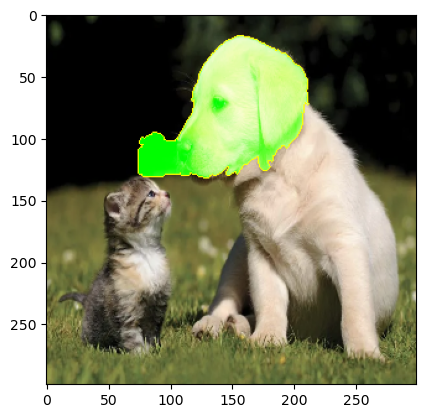

In [50]:
from skimage.segmentation import mark_boundaries

# Display the explanation using matplotlib
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, 
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

SURPRISINGLY, the algorithm only focuses on small region of this image to classify the dog. So in the future, we can know that why the model may not predict well the object and try to train the model on this focused region to enhance its performance.

**Step 7: (Optional) Visualize the Important Regions :**

This step extracts information about the top predicted label and creates a heatmap to visualize how each segment of the image contributes to the prediction. The `ind` variable stores the top label's index, and `dict_heatmap` maps segments to their impact on the prediction. The heatmap is generated by associating segment values with their impact and using a color map ('RdBu') to visualize it. The color scale is centered around zero, with negative and positive influences indicated by different colors. A color bar is added to provide a reference for the heatmap values.

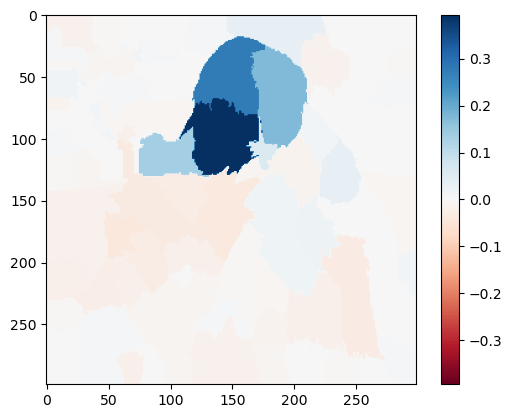

In [51]:
ind = explanation.top_labels[0]

dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

plt.imshow(heatmap, cmap='RdBu', vmin= -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

You can play with other images in data folder in this repo.

## 3. SHAP

Shapley Values (SHAP):

- Shapley Values are a concept borrowed from cooperative game theory and have been adapted for model interpretation.
- They provide a way to fairly distribute the contribution of each feature to a model's prediction.
- Shapley Values explain the impact of individual features on a particular prediction by measuring the average contribution of a feature when it is added to all possible subsets of features.
- They offer a unified and consistent way to attribute predictions to feature values, making them model-agnostic.
- Shapley Values can reveal not only the importance of features but also how interactions between features influence a prediction.
- SHAP (SHapley Additive exPlanations) is a Python library that implements Shapley Values for model explanation. It is widely used for various types of machine learning models.

In this example, we will use SHAP to explain for classification task of Breast Cancer from UCI Dataset.

Link:https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

### 3.0 Load data

In [59]:
data = pd.read_csv('./data/breast-cancer-wisconsin.data', header=None)
data.columns=['Id number','Clump Thickness','Uniformity of Cell Size','Uniformity of Cell Shape','Marginal Adhesion','Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses','Class']
data2 = data.apply(pd.to_numeric, errors='coerce') #Convert argument to numeric type and invalid parsing is set as NaN
data = data2.dropna() #Rewrrite previous data entry with new complete data 

#Patient Number is not required
del data['Id number']

# Display the first few records
data.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1.0,3,1,1,2
1,5,4,4,5,7,10.0,3,2,1,2
2,3,1,1,1,2,2.0,3,1,1,2
3,6,8,8,1,3,4.0,3,7,1,2
4,4,1,1,3,2,1.0,3,1,1,2


In [62]:
# Check data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Clump Thickness              683 non-null    int64  
 1   Uniformity of Cell Size      683 non-null    int64  
 2   Uniformity of Cell Shape     683 non-null    int64  
 3   Marginal Adhesion            683 non-null    int64  
 4   Single Epithelial Cell Size  683 non-null    int64  
 5   Bare Nuclei                  683 non-null    float64
 6   Bland Chromatin              683 non-null    int64  
 7   Normal Nucleoli              683 non-null    int64  
 8   Mitoses                      683 non-null    int64  
 9   Class                        683 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 58.7 KB


### 3.1 Run the model

In [78]:
# Import library
from sklearn.ensemble import RandomForestClassifier

In [77]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :9], # train for first 3 variables
                                                    data.iloc[:, 9], # test is the last variable
                                                    test_size=0.2, # 20% for testing
                                                    random_state = 123)

In [79]:
# Fit the model
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
print(f"Score: {clf.score(X_test, y_test)}")

Score: 0.9781021897810219


### 3.2 Explain model with SHAP

You can follow the guide from this youtube: https://www.youtube.com/watch?v=2xlgOu22YgE&t=1s&ab_channel=ADataOdyssey

In [110]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

**a. Feature Importance Plot**

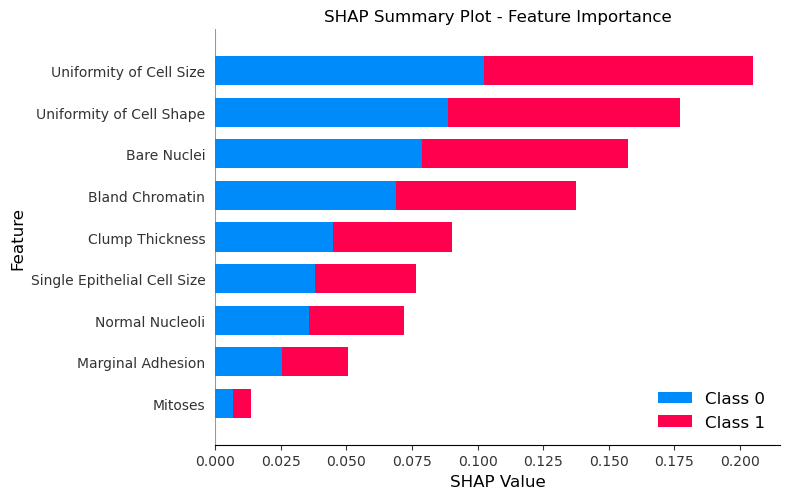

In [111]:
# Create a summary plot with the bar plot type
shap.summary_plot(shap_values, X_train, plot_type='bar', show=False)

# Customize the plot appearance
plt.title("SHAP Summary Plot - Feature Importance")
plt.xlabel("SHAP Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

This plot shows feature importance of the model in order and gives us information about how each feature could explain each class of data.

**b. Force Plot**

The SHAP force plot is a visualization that helps explain the output of a machine learning model at the individual prediction level. It provides a detailed breakdown of how each feature contributes to the prediction for a specific instance or observation.

In [126]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0, :], X_train.iloc[0], figsize=10)

**c. Water fall plot**

The SHAP waterfall plot is a valuable tool for explaining individual predictions made by machine learning models. It offers a clear, step-by-step breakdown of feature contributions, which is essential for understanding model behavior and providing interpretability to users and stakeholders.

In [143]:
explainer_2 = shap.Explainer(clf)
shap_values_cat = explainer_2(X_train)

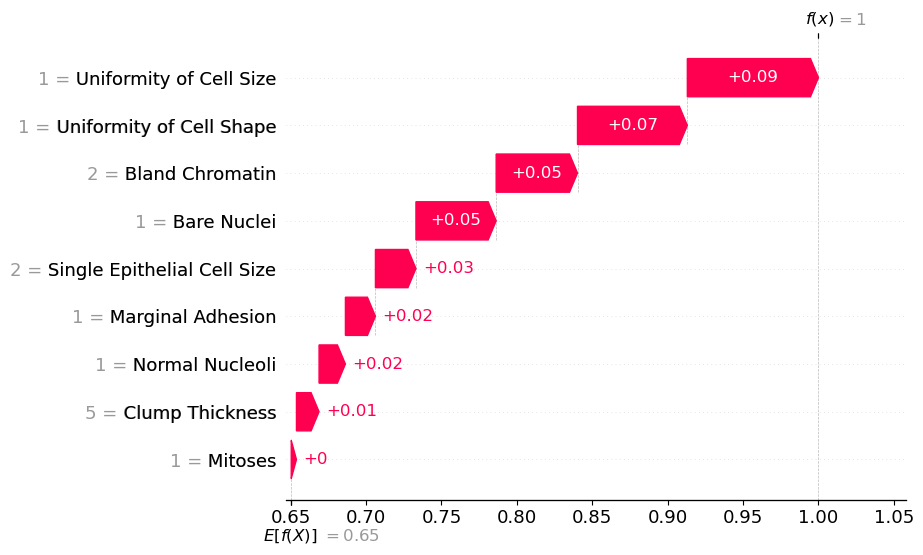

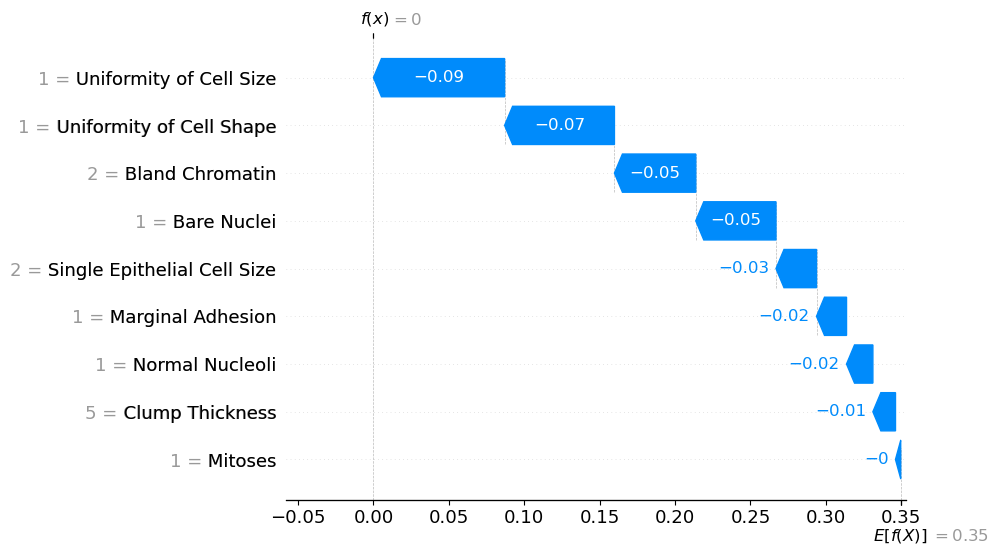

In [146]:
shap.plots.waterfall(shap_values_cat[0,:,0])
shap.plots.waterfall(shap_values_cat[0,:,1])

## Summary

Here's a comparison table for SHAP, LIME (Local Interpretable Model-agnostic Explanations), and Partial Dependence Plot (PDP). These are common techniques used for model interpretability and understanding feature importance.

| Aspect                              | SHAP                                  | LIME                                | Partial Dependence Plot (PDP)    |
|-------------------------------------|---------------------------------------|-------------------------------------|----------------------------------|
| Purpose                             | Explain individual prediction outcomes | Explain individual prediction outcomes | Analyze the relationship between one or more features and the model's prediction |
| Model Agnostic                      | Yes                                   | Yes                                 | No                               |
| Local vs. Global Interpretability   | Both local and global explanations     | Mainly local explanations            | Mostly global explanations       |
| Sample Size                         | Usually works with a sample of data   | Typically works with individual instances | Works with the entire dataset  |
| Output                              | Provides feature contributions for each prediction | Approximates feature importance for individual predictions | Shows the effect of one or more features on predictions |
| Methodology                         | Uses Shapley values and game theory for feature attributions | Trains an interpretable model locally for each prediction | Evaluates model predictions while varying one or more features |
| Interpretability                    | Offers a comprehensive understanding of feature contributions and interactions | Offers simplified approximations for local explanations | Provides a global view of feature impact on model output |
| Complexity                          | Potentially complex, but capable of handling complex models and interactions | Typically simpler as it trains interpretable models, but may not capture complex interactions | Simple visualizations, easier to understand, but may not capture complex interactions |
| Usage                              | Commonly used for complex models like XGBoost, neural networks, etc. | Suitable for both simple and complex models | Suitable for models of varying complexity |
| Plot Types Available                | Summary plots, dependence plots, force plots, and more | Local explanation plots | Partial dependence plots, 2D PDPs, etc. |
| Trade-offs                         | Provides a comprehensive understanding but can be complex to interpret | Offers simpler, localized explanations, but may not capture all feature interactions | Provides a global view but may not fully explain complex interactions |
| Suitability                        | Well-suited for detailed feature explanations and complex models | Suitable for local, instance-specific interpretations | Useful for understanding the impact of one or more features on model predictions |
| Customization                      | Highly customizable with various plot types and options | Some degree of customization, especially in the choice of interpretable model | Limited customization for individual PDP plots |
| Dependencies                       | Requires the SHAP library | Requires the LIME library | Typically available in machine learning libraries like scikit-learn |
| Summary                            | SHAP is powerful for comprehensive model explanations and feature interactions. | LIME is useful for generating interpretable models for individual predictions. | PDP is great for understanding the overall impact of features on model predictions. |
   
This table provides an overview of the characteristics and use cases of SHAP, LIME, and Partial Dependence Plot. Depending on your specific interpretability needs and the complexity of your model, you can choose the most appropriate technique or combine them to gain a holistic understanding of your model's behavior.